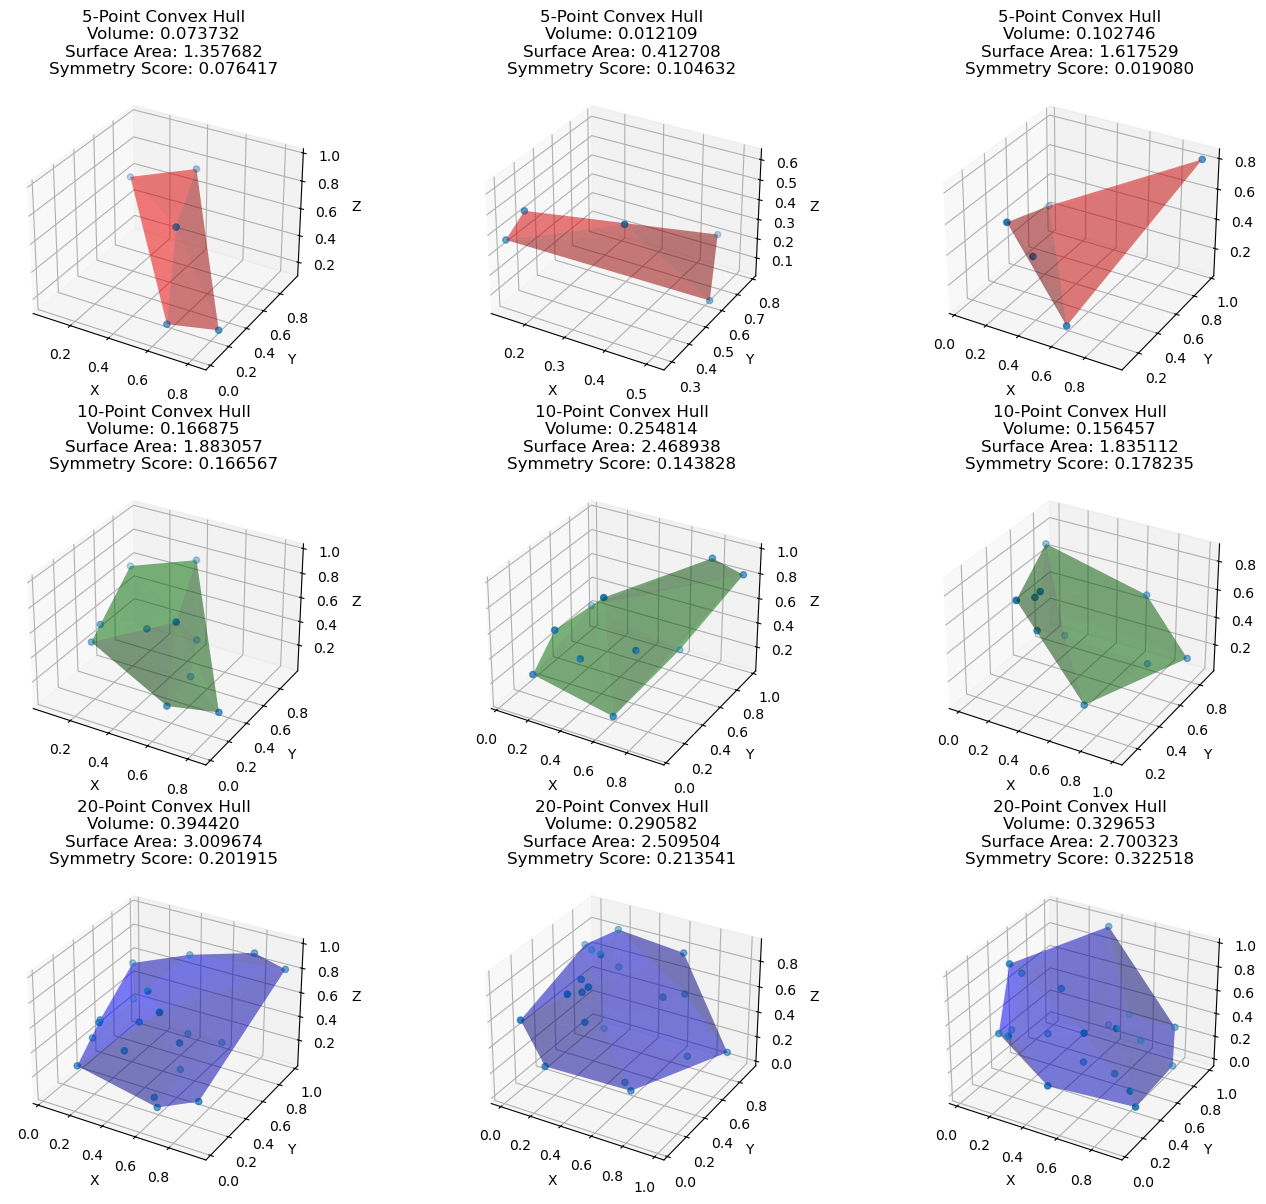

: 

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist

# Set the data directory
data_dir1 = Path("/home/ajay/GATr-experiments/tmp/gatr-experiments/data/volume")
data_dir2 = Path("/home/ajay/GATr-experiments/tmp/gatr-experiments/data/volume_10") 
data_dir = Path("/home/ajay/GATr-experiments/tmp/gatr-experiments/data/volume_20")

# Function to compute symmetry score based on the provided implementation
def compute_symmetry_score(points):
    """Compute symmetry score for a set of convex hull points."""
    centroid = np.mean(points, axis=0)
    reflected_points = 2 * centroid - points
    distances = cdist(points, reflected_points)
    min_distances = np.min(distances, axis=1)
    bbox_size = np.max(points, axis=0) - np.min(points, axis=0)
    diagonal = np.sqrt(np.sum(bbox_size**2))
    symmetry_score = np.exp(-np.mean(min_distances) / (diagonal * 0.1))
    return symmetry_score

# Function to plot points and convex hull with metrics
def plot_points(points, ax, title, hull_color='blue'):
    # Plot the points
    ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    
    # Create convex hull and plot
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        vertices = points[simplex]
        ax.plot_trisurf(vertices[:,0], vertices[:,1], vertices[:,2], 
                       alpha=0.3, color=hull_color)
    
    # Compute metrics
    symmetry = compute_symmetry_score(points)
    surface_area = hull.area
    
    # Update title with all metrics
    ax.set_title(f"{title}\nSurface Area: {surface_area:.6f}\nSymmetry Score: {symmetry:.6f}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Load all datasets
all_datasets = {}
for dir_path, n_points in [(data_dir1, 5), (data_dir2, 10), (data_dir, 20)]:
    datasets = {}
    for name in ['train', 'test', 'val', 'generalization']:
        data = np.load(dir_path / f"{name}.npz")
        datasets[name] = {
            'points': data['points'],
            'volumes': data['volumes']
        }
    all_datasets[n_points] = datasets

# Create figure with 9 subplots (3 rows for different point counts, 3 columns for examples)
fig = plt.figure(figsize=(15, 12))

# Add more vertical spacing between rows
plt.subplots_adjust(hspace=0.5)

for i, n_points in enumerate([5, 10, 20]):
    hull_color = 'red' if i == 0 else 'green' if i == 1 else 'blue'
    for j in range(3):  # Plot first 3 examples
        ax = fig.add_subplot(3, 3, i*3 + j + 1, projection='3d')
        points = all_datasets[n_points]['train']['points'][j]
        volume = all_datasets[n_points]['train']['volumes'][j]
        plot_points(points, ax, f"{n_points}-Point Convex Hull\nVolume: {volume:.6f}", hull_color)

plt.tight_layout()
plt.savefig('convex_hulls_comparison.png', dpi=300, bbox_inches='tight')
plt.show()